In [1]:
from pathlib import Path
from src.visualization.render_mp4 import mp4_from_pickle_jupyter, unpickle_data
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [2]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="one_leg",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/*.pkl*


(242,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T16:40:00.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T16:37:45.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T15:09:00.pkl.xz')])

In [3]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 242/242 [00:41<00:00,  5.78it/s]


In [4]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-12T16:40:00.pkl.mp4


File saved as 2024-02-12T16:37:45.pkl.mp4


File saved as 2024-02-12T15:09:00.pkl.mp4


File saved as 2024-02-12T17:07:55.pkl.mp4


File saved as 2024-02-12T17:25:49.pkl.mp4


## Look at state-space coverage

### Load in the data

In [5]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [6]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="one_leg",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/one_leg/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr'))

In [7]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# Get the skill labels for the teleop data and split them into episodes
skill_teleop = z_teleop["skill"][:]
skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# For the teleop data, we slice off the data after the insertion
pos_teleop = [
    ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [8]:
len(skill_teleop), len(pos_teleop), len(pos_aug)

(50, 16126, 13939)

### Plot the state-space coverage in 3D

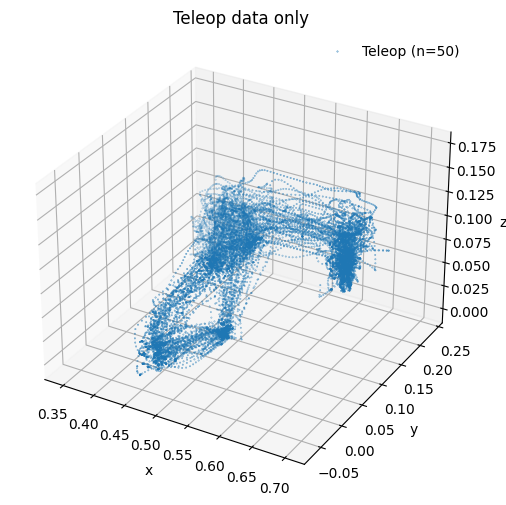

In [9]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 121 for a 1x2 grid, first position
ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)
ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# # Add a subplot for augmentation data in the right side of the figure
# ax2 = fig.add_subplot(
#     122, projection="3d"
# )  # Changed from 111 to 122 for a 1x2 grid, second position
# ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
# ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
# ax2.legend(frameon=False)
# ax2.set_title("Teleop and augmentation data")
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("z")

# # Title for the whole figure
# fig.suptitle(
#     "Teleop and augmentation data for `one_leg` task for V2 of augmentation system (Feb. 14, 2024)"
# )

plt.show()

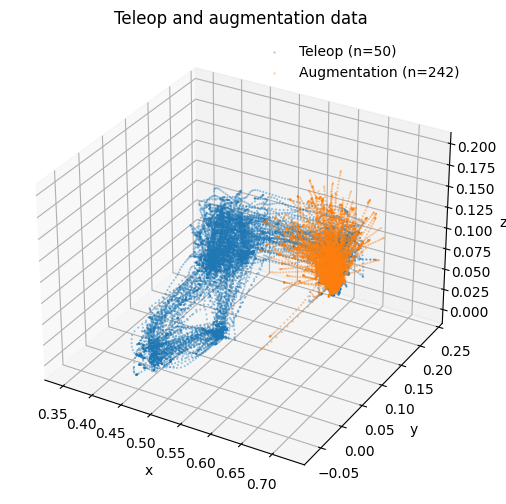

In [10]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

## Analyze the `round_table` augmentation

### Qualitatively analyze trajectories

In [11]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [12]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="round_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/*.pkl*


(514,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T19:21:51.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T20:42:30.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T19:15:30.pkl.xz')])

In [13]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

 56%|█████▌    | 288/514 [00:47<01:00,  3.74it/s]

Failed to load /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-18T09:55:12.pkl.xz


100%|██████████| 514/514 [01:27<00:00,  5.85it/s]


In [14]:
for path in paths[:100]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-17T19:21:51.pkl.mp4


File saved as 2024-02-17T20:42:30.pkl.mp4


File saved as 2024-02-17T19:15:30.pkl.mp4


File saved as 2024-02-17T20:05:45.pkl.mp4


File saved as 2024-02-17T21:18:49.pkl.mp4


File saved as 2024-02-17T20:04:04.pkl.mp4


File saved as 2024-02-17T19:40:19.pkl.mp4


File saved as 2024-02-17T21:13:19.pkl.mp4


File saved as 2024-02-17T20:35:21.pkl.mp4


File saved as 2024-02-17T21:05:18.pkl.mp4


File saved as 2024-02-17T19:24:44.pkl.mp4


File saved as 2024-02-17T19:17:44.pkl.mp4


File saved as 2024-02-17T20:52:00.pkl.mp4


File saved as 2024-02-17T19:16:10.pkl.mp4


File saved as 2024-02-17T21:14:53.pkl.mp4


File saved as 2024-02-17T21:23:45.pkl.mp4


File saved as 2024-02-18T09:57:58.pkl.mp4


File saved as 2024-02-17T22:20:31.pkl.mp4


File saved as 2024-02-17T22:48:06.pkl.mp4


File saved as 2024-02-17T22:19:26.pkl.mp4


File saved as 2024-02-17T20:40:21.pkl.mp4


File saved as 2024-02-17T18:57:51.pkl.mp4


File saved as 2024-02-17T22:34:19.pkl.mp4


File saved as 2024-02-17T21:26:15.pkl.mp4


File saved as 2024-02-17T21:13:40.pkl.mp4


File saved as 2024-02-17T22:50:28.pkl.mp4


File saved as 2024-02-18T09:58:21.pkl.mp4


File saved as 2024-02-17T22:42:55.pkl.mp4


File saved as 2024-02-17T19:35:30.pkl.mp4


File saved as 2024-02-17T21:49:46.pkl.mp4


File saved as 2024-02-17T22:24:40.pkl.mp4


File saved as 2024-02-17T21:36:24.pkl.mp4


File saved as 2024-02-17T19:02:47.pkl.mp4


File saved as 2024-02-17T20:26:24.pkl.mp4


File saved as 2024-02-17T21:17:58.pkl.mp4


File saved as 2024-02-17T21:15:26.pkl.mp4


File saved as 2024-02-17T22:51:52.pkl.mp4


File saved as 2024-02-17T19:44:14.pkl.mp4


File saved as 2024-02-17T21:38:37.pkl.mp4


File saved as 2024-02-17T22:16:00.pkl.mp4


File saved as 2024-02-17T21:47:35.pkl.mp4


File saved as 2024-02-17T22:31:11.pkl.mp4


File saved as 2024-02-17T18:54:45.pkl.mp4


File saved as 2024-02-17T19:26:09.pkl.mp4


File saved as 2024-02-17T20:36:49.pkl.mp4


File saved as 2024-02-17T21:43:47.pkl.mp4


File saved as 2024-02-17T20:19:05.pkl.mp4


File saved as 2024-02-17T21:07:17.pkl.mp4


File saved as 2024-02-17T19:23:04.pkl.mp4


File saved as 2024-02-17T20:13:31.pkl.mp4


File saved as 2024-02-17T21:56:45.pkl.mp4


File saved as 2024-02-17T21:25:23.pkl.mp4


File saved as 2024-02-17T22:06:55.pkl.mp4


File saved as 2024-02-17T22:56:00.pkl.mp4


File saved as 2024-02-17T20:05:24.pkl.mp4


File saved as 2024-02-17T22:38:02.pkl.mp4


File saved as 2024-02-17T20:14:27.pkl.mp4


File saved as 2024-02-17T22:25:42.pkl.mp4


File saved as 2024-02-17T19:10:01.pkl.mp4


File saved as 2024-02-17T19:18:07.pkl.mp4


File saved as 2024-02-17T19:24:23.pkl.mp4


File saved as 2024-02-17T21:46:51.pkl.mp4


File saved as 2024-02-17T19:26:33.pkl.mp4


File saved as 2024-02-17T21:21:24.pkl.mp4


File saved as 2024-02-17T19:35:45.pkl.mp4


File saved as 2024-02-17T21:32:07.pkl.mp4


File saved as 2024-02-17T22:48:39.pkl.mp4


File saved as 2024-02-17T21:22:59.pkl.mp4


File saved as 2024-02-17T20:48:31.pkl.mp4


File saved as 2024-02-17T22:23:36.pkl.mp4


File saved as 2024-02-17T22:26:22.pkl.mp4


File saved as 2024-02-17T20:24:45.pkl.mp4


File saved as 2024-02-17T21:54:46.pkl.mp4


File saved as 2024-02-17T19:46:33.pkl.mp4


File saved as 2024-02-17T19:53:35.pkl.mp4


File saved as 2024-02-17T21:17:33.pkl.mp4


File saved as 2024-02-17T21:13:05.pkl.mp4


File saved as 2024-02-17T19:44:36.pkl.mp4


File saved as 2024-02-17T18:57:00.pkl.mp4


File saved as 2024-02-17T19:13:14.pkl.mp4


File saved as 2024-02-17T20:17:05.pkl.mp4


File saved as 2024-02-17T21:52:04.pkl.mp4


File saved as 2024-02-17T22:58:00.pkl.mp4


File saved as 2024-02-17T21:50:10.pkl.mp4


File saved as 2024-02-17T22:38:17.pkl.mp4


File saved as 2024-02-17T19:35:58.pkl.mp4


File saved as 2024-02-17T21:19:07.pkl.mp4


File saved as 2024-02-17T20:44:41.pkl.mp4


File saved as 2024-02-17T21:27:54.pkl.mp4


File saved as 2024-02-17T20:37:35.pkl.mp4


File saved as 2024-02-17T21:38:05.pkl.mp4


File saved as 2024-02-18T09:57:34.pkl.mp4


File saved as 2024-02-17T18:55:13.pkl.mp4


File saved as 2024-02-17T21:28:43.pkl.mp4


File saved as 2024-02-17T21:22:16.pkl.mp4


File saved as 2024-02-17T20:53:08.pkl.mp4


File saved as 2024-02-17T21:45:46.pkl.mp4


File saved as 2024-02-17T21:55:36.pkl.mp4


File saved as 2024-02-17T21:45:04.pkl.mp4


File saved as 2024-02-17T19:49:21.pkl.mp4


### Plot coverage of new trajectories

In [15]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [16]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="round_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr'))

In [17]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [18]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 47246, 500, 28105)

### Plot the state-space coverage in 3D

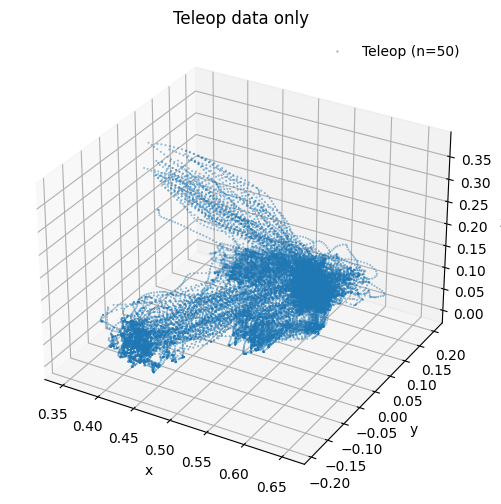

In [19]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 121 for a 1x2 grid, first position
ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)
ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

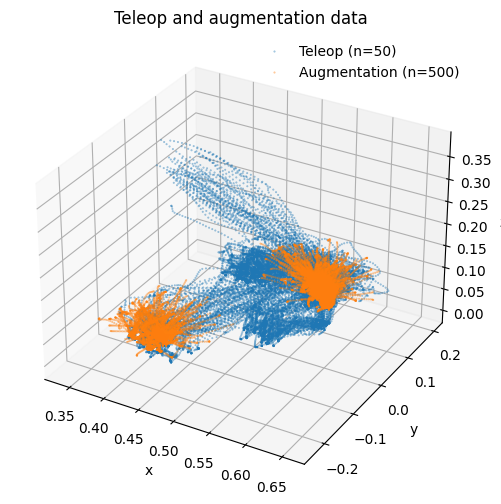

In [20]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

## Analyze the `lamp` augmentation

### Qualitatively analyze trajectories

In [21]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [22]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="lamp",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/*.pkl*


(542,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T16:43:14.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T19:06:43.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T20:19:27.pkl.xz')])

In [23]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 542/542 [01:22<00:00,  6.58it/s]


In [24]:
for path in paths[:25]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-19T16:43:14.pkl.mp4


File saved as 2024-02-19T19:06:43.pkl.mp4


File saved as 2024-02-19T20:19:27.pkl.mp4


File saved as 2024-02-19T19:56:55.pkl.mp4


File saved as 2024-02-19T19:10:39.pkl.mp4


File saved as 2024-02-19T20:20:40.pkl.mp4


File saved as 2024-02-19T19:12:27.pkl.mp4


File saved as 2024-02-19T20:16:55.pkl.mp4


File saved as 2024-02-19T19:22:46.pkl.mp4


File saved as 2024-02-19T21:13:11.pkl.mp4


File saved as 2024-02-19T21:02:29.pkl.mp4


File saved as 2024-02-19T20:21:27.pkl.mp4


File saved as 2024-02-19T19:29:28.pkl.mp4


File saved as 2024-02-19T20:24:00.pkl.mp4


File saved as 2024-02-19T20:13:24.pkl.mp4


File saved as 2024-02-19T20:34:13.pkl.mp4


File saved as 2024-02-19T21:05:26.pkl.mp4


File saved as 2024-02-19T20:44:05.pkl.mp4


File saved as 2024-02-19T20:22:38.pkl.mp4


File saved as 2024-02-19T16:48:09.pkl.mp4


File saved as 2024-02-19T19:20:46.pkl.mp4


File saved as 2024-02-19T20:47:53.pkl.mp4


File saved as 2024-02-19T21:38:53.pkl.mp4


File saved as 2024-02-19T21:01:44.pkl.mp4


File saved as 2024-02-19T20:14:32.pkl.mp4


### Plot coverage of new trajectories

In [25]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [26]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="lamp",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr'))

In [27]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [28]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 43267, 542, 28012)

### Plot the state-space coverage in 3D

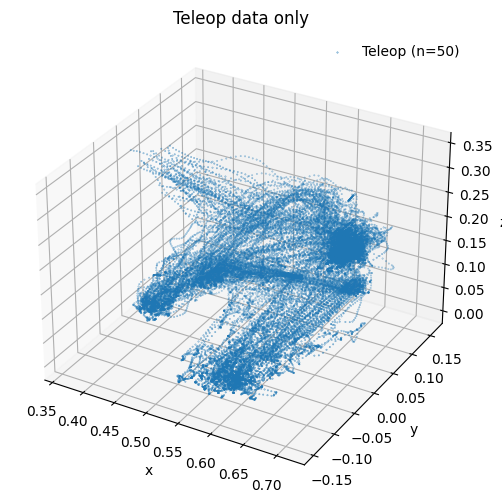

In [30]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)

ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

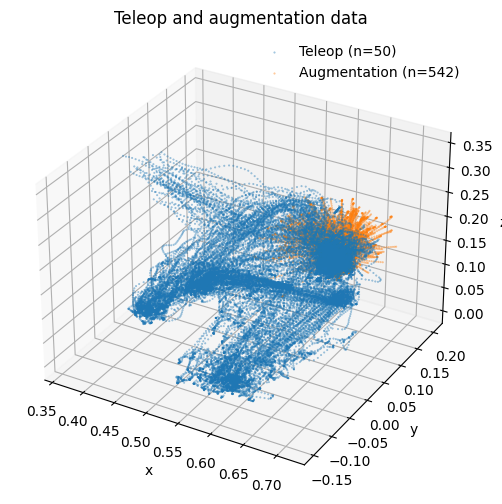

In [31]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

## Analyze the `square_table` augmentation

In [32]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [33]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="square_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/*.pkl*


(258,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T16:08:18.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T13:24:36.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T14:22:16.pkl.xz')])

In [34]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 258/258 [00:44<00:00,  5.79it/s]


In [35]:
for path in paths[:10]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-20T16:08:18.pkl.mp4


File saved as 2024-02-20T13:24:36.pkl.mp4


File saved as 2024-02-20T14:22:16.pkl.mp4


File saved as 2024-02-20T16:51:46.pkl.mp4


File saved as 2024-02-19T22:12:14.pkl.mp4


File saved as 2024-02-20T12:30:38.pkl.mp4


File saved as 2024-02-20T14:51:58.pkl.mp4


File saved as 2024-02-20T15:32:24.pkl.mp4


File saved as 2024-02-20T11:59:20.pkl.mp4


File saved as 2024-02-19T22:04:52.pkl.mp4


In [36]:
# One-off fix a mislabeled file
file = None
data = unpickle_data(file)
del data["augment_states"]
pickle_data(data, file)

TypeError: expected str, bytes or os.PathLike object, not NoneType

### Plot coverage of new trajectories

In [ ]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [ ]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="square_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr'))

In [ ]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [ ]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(63, 53584, 286, 15378)

In [ ]:
# Sample a subset of the data
idx = np.random.choice(len(pos_teleop), size=53584, replace=False)
pos_teleop = pos_teleop[idx]

### Plot the state-space coverage in 3D

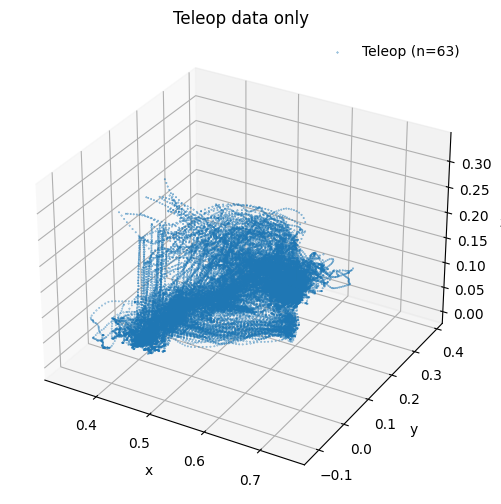

In [ ]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)

ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

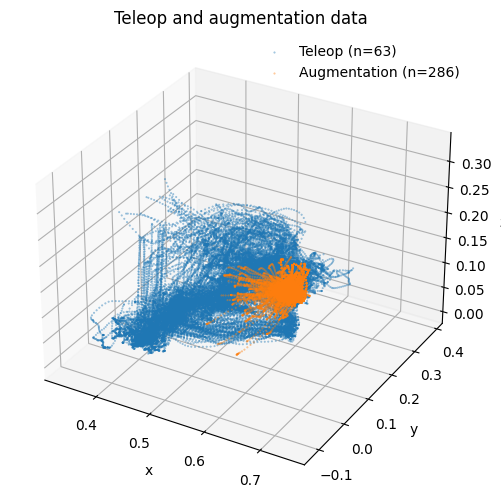

In [ ]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

In [ ]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [ ]:
paths = get_raw_paths(
    environment="sim",
    demo_source="teleop",
    demo_outcome="success",
    task="square_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/*.pkl*


(50,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T21:24:13.pkl'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T21:01:58.pkl'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T09:21:51.pkl')])

In [ ]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

  0%|          | 0/50 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-19T21:24:13.mp4


File saved as 2024-02-19T21:01:58.mp4


File saved as 2024-02-19T09:21:51.mp4


File saved as 2024-02-19T12:02:09.mp4


File saved as 2024-02-19T20:58:08.mp4
